In [1]:
!python --version

Python 3.7.7


In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pandas.plotting import andrews_curves
import pylab
import pandas as pd
import numpy as np
import warnings
import glob
warnings.filterwarnings('ignore')

## Get tables and compute accuracy

In [3]:
import os
import json

filepath='simulation/coco_query_dnf_gt.csv'
if os.path.isfile(filepath):
    print ("Query file exist")
    df_query = pd.read_csv(filepath,index_col=0)
#     df_query = df_query[df_query['form']=='dnf']
    queryList = list(df_query['query'])
    indexList = list(df_query['index'])#list(df_query['index'])#[json.loads(l) for l in list(df_query['index'])]
queryList

Query file exist


['(chair | car)',
 '(tv & bottle) | cup',
 '(chair & car) | (person & tv)',
 'bottle | (cup & bowl) | (person & chair)',
 '(bottle & person) | (bowl & car) | (tv & cup)']

In [4]:
df_query['index']

0    ['000000173302.jpg', '000000174231.jpg', '0000...
1    ['000000173371.jpg', '000000173383.jpg', '0000...
2    ['000000177861.jpg', '000000180383.jpg', '0000...
3    ['000000173091.jpg', '000000173302.jpg', '0000...
4    ['000000173302.jpg', '000000174371.jpg', '0000...
Name: index, dtype: object

In [5]:
# identify evaluation set & test set
split_range = 5000*0.4
split_range

2000.0

## Retrieve query index that match the queries

In [6]:
constraint = 'cost'

def getRecords(folder,constraint):
    
    path = 'output/'+folder+'/summary_'+constraint+'_optimizer.csv'
    df_opt = pd.read_csv(path,index_col=0)

    path = 'output/'+folder+'/summary_order_'+constraint+'_optimizer.csv'
    df_order_opt = pd.read_csv(path,index_col=0)

    path = 'output/'+folder+'/summary_'+constraint+'_baseline_pareto.csv'
    df_baseline = pd.read_csv(path,index_col=0)
    return [df_baseline,df_opt,df_order_opt]

In [ ]:
df_records_list = getRecords('coco','cost')

## Model repository

In [ ]:
df_model = pd.read_csv('repository/model_stats_ap.csv',index_col=0)
df_model

## Model assignment statistics

In [7]:
# model.predicate
def modelAssignmentCount(df_records_list):
    labels = ['baseline','basic_opt','order_opt']

    model_assignment_count = {}
    for idx in range(10):
        for i,df in enumerate(df_records_list):
            subset = df[(df.query_index==idx)]
            for idx,row in subset.iterrows():
                selected_model = row.selected_model#.values[0]
                if type(selected_model)==str:
                    for item in selected_model.split('|'):
                        model_assignment_count[item] = model_assignment_count.get(item, 0) + 1

    model_assignment_count = {k: v for k, v in sorted(model_assignment_count.items(), key=lambda item: item[1],reverse=True)}
    return model_assignment_count

def modelCount(df_records_list):
    labels = ['baseline','basic_opt','order_opt']
    model_count = {}
    for idx in range(10):
        for i,df in enumerate(df_records_list):
            subset = df[(df.query_index==idx)]
            for idx,row in subset.iterrows():
                selected_model = row.selected_model#.values[0]
                if type(selected_model)==str:
                    for item in selected_model.split('|'):
                        key = item.split('.')[1]
                        model_count[key] = model_count.get(key, 0) + 1

    model_count = {k: v for k, v in sorted(model_count.items(), key=lambda item: item[1],reverse=True)}
    return model_count


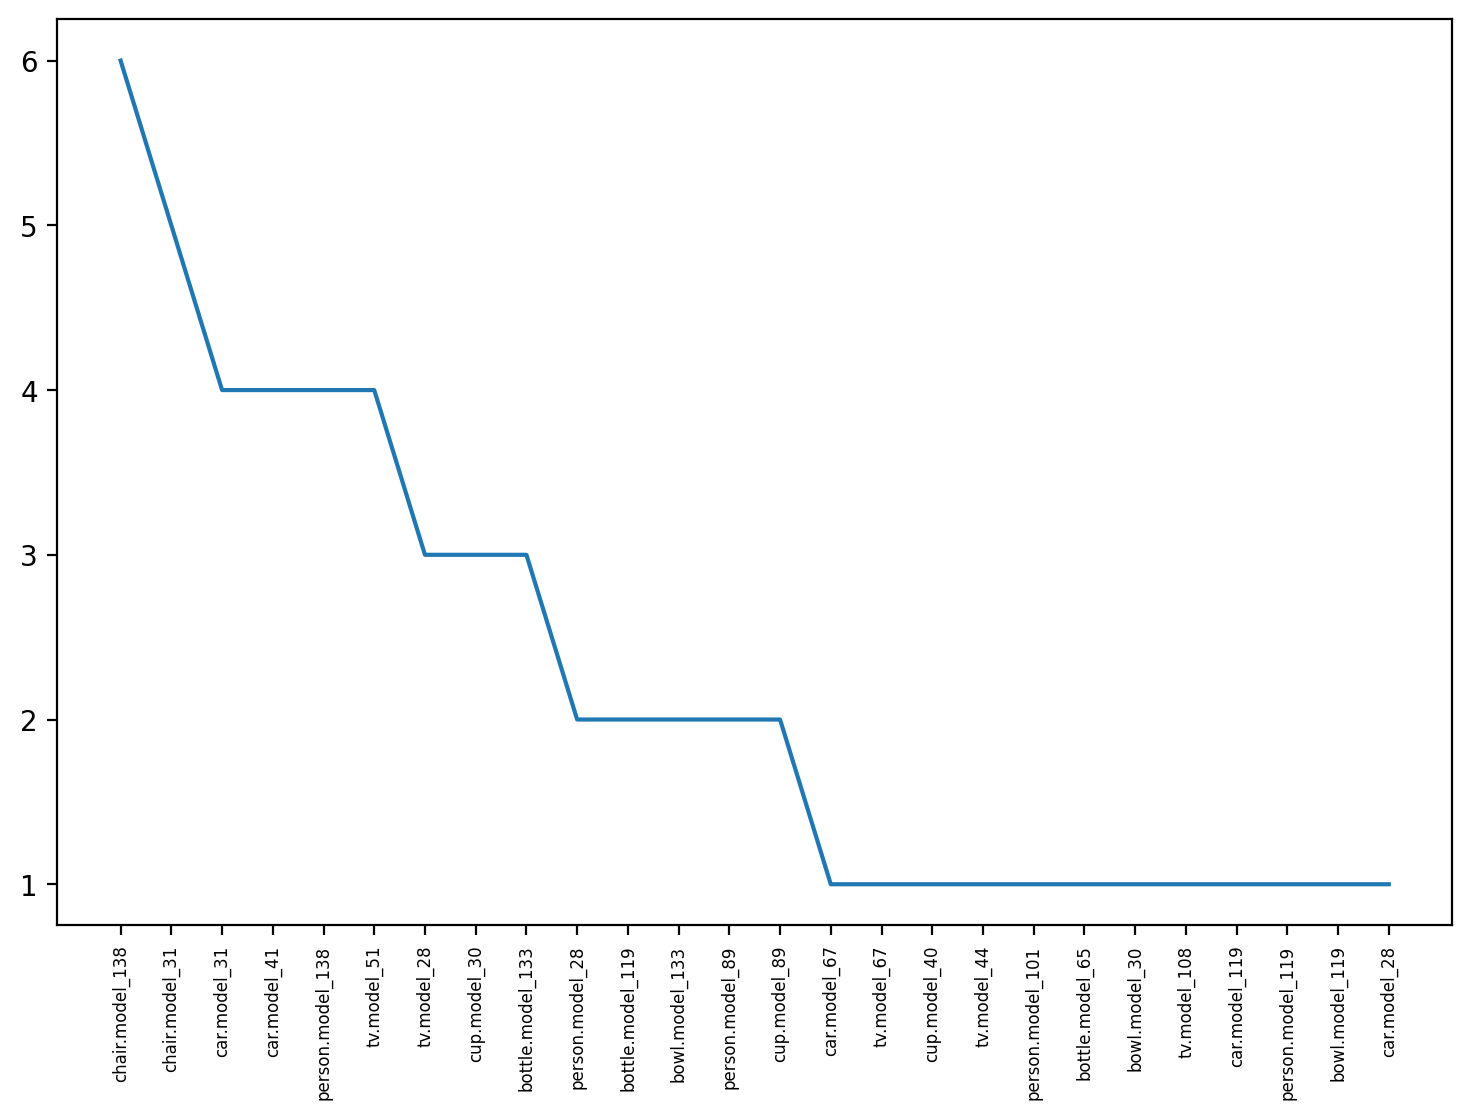

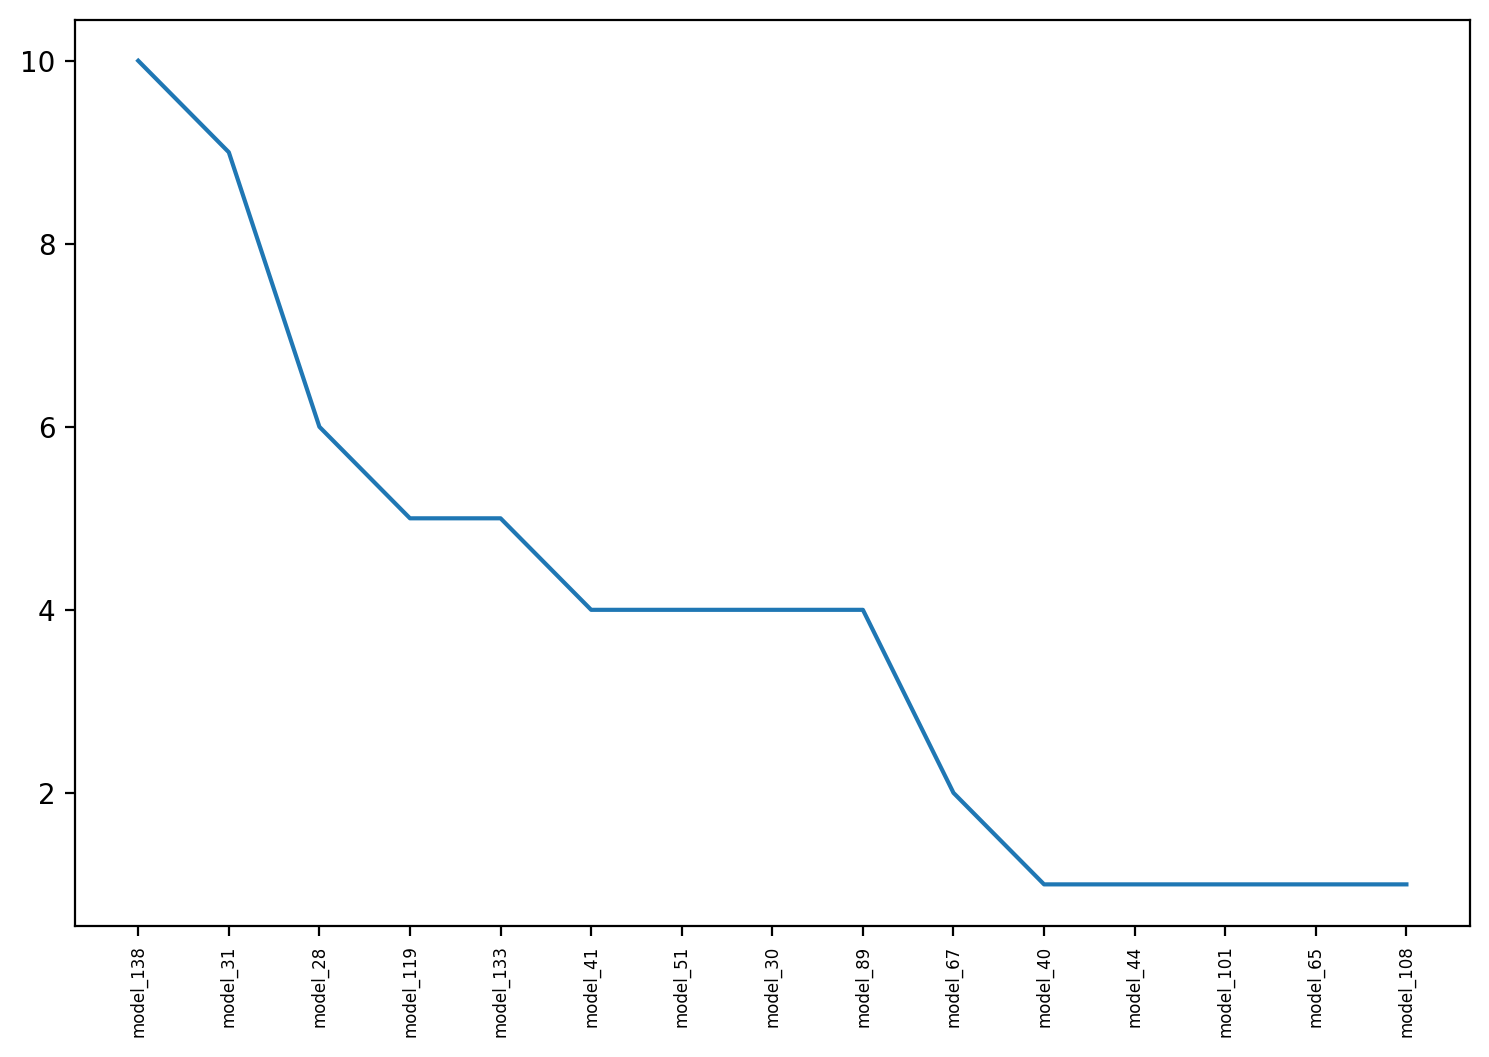

In [10]:
# model count
df_records_rm_2_list = getRecords('coco_f1_dnf','cost')
model_assignment_count = modelAssignmentCount(df_records_rm_2_list)
model_count  = modelCount(df_records_rm_2_list)

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(list(model_assignment_count.keys()),list(model_assignment_count.values()))
ax.tick_params(axis='x', rotation=90,labelsize=6)
plt.savefig('image/model_assignment_count.eps',format='eps')
# plt.xticks(model_assignment_count.keys(),rotation=90)

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(list(model_count.keys()),list(model_count.values()))
ax.tick_params(axis='x', rotation=90,labelsize=6)
plt.savefig('image/model_count.eps',format='eps')


## Collect statistics

In [8]:
import glob
import re
import pandas as pd
from sympy.parsing.sympy_parser import parse_expr

In [9]:
import numpy as np
def getImageIndex(query,df):
    Bxp = parse_expr(query)
    predicates = [str(p) for p in list(Bxp.atoms())]
    print(predicates)
    subset = df[predicates].dropna(how='all')
    # subset.replace(0, np.nan, inplace=True)
    # not null
    subset = pd.notnull(subset)
    # > threshold
#     subset = subset>0.3

#     subset[subset != 0] = True
    index = []
    for i, row in subset.iterrows():
        if Bxp.subs({p:row[str(p)] for p in list(Bxp.atoms())}) == True: 
            try:
                index.append(df.loc[i,:]['filename'])
            except:
                continue
                    
#     index = [i for i, row in subset.iterrows() if Bxp.subs({p:row[str(p)] for p in list(Bxp.atoms())}) == True ]
#     print('len(index)',len(index))
    return index

In [10]:
def getCostList(path_list):
    cost_list_all = []
    cost_list = []
    for i,paths in enumerate(path_list):
        print('paths',paths)
        df = pd.read_csv(paths,index_col=0)
        cost_list.append(df)
#         for j,path in enumerate(paths):
            # path = 'results/results_2nd.csv'
#             print(path)
            
#             if j == 2:
#                 print(df.head())
            
#         cost_list_all.append(cost_list)
    return cost_list

In [11]:
def getResults(df_result,constraint,cost_path_list,folder_list,df_records_list):
#     constraint = 'cost'

#     cost_list = getCostList(cost_path_list) #['results/results_1st.csv','results/results_2nd.csv'])
    
    for i,folder in enumerate(folder_list):
        
        df_cost_order = pd.read_csv(folder+'time_order_opt.csv')
        df_cost_basic = pd.read_csv(folder+'time_basic_opt.csv')
        df_cost_baseline = pd.read_csv(folder+'time_baseline.csv')

        print('i',i)
#         print(len(cost_list))
        
        print('folder',folder)
        for file in glob.glob(folder+"*"):
            print(file)
            df = pd.read_csv(file)
            print(df.shape)

            name = file.split('/')[-1].split('.')[0]
            print('name',name)
            if len(name.split('_')) < 4:
                continue

            if not df_result[(df_result['name'] == name) & (df_result['pass']==i)].empty:
                continue

            # retrieve cost
            order = 'order' in name
            print('order',order)
                
            if order:
                df_record = df_records_list[2]
                df_cost = df_cost_order#cost_list[3*i+2]
                approach = 'order_opt'
            elif 'basic' in name:
                df_record = df_records_list[1]
                df_cost = df_cost_basic#cost_list[3*i+1]
                approach = 'basic_opt'
            else:
                df_record = df_records_list[0]
                df_cost = df_cost_baseline#cost_list[3*i+2]
                approach = 'baseline'
                
            df_cost = df_cost[df_cost['scriptname']==name]
            total_cost = df_cost['total'].sum()
            inference = df_cost['model_inference'].sum()
            print('cost',total_cost)

            

            query_idx = int(re.search(r'\d+', name).group(0))
            query = df_query['query'][query_idx]
            print('query_idx',query_idx)
            
            consr_type = re.search(r'.*_([a-z]+)_.*', name).group(1)
            print('constraint',consr_type)
            if consr_type != constraint:
                continue

            bound = re.search(r'.*_(\d+)', name).group(1)
            print('bound',bound)

            # Match objective value with extracted accuracy results
            record = df_record[(df_record['query_index']==query_idx) & (df_record['constraint']==constraint) \
                               & (df_record['bound']==int(bound))]

            # get image index and compute accuracy
            index = getImageIndex(query,df)
            gt = indexList[query_idx]
            label = gt.strip("[]").replace("'","").split(', ')
            
#             predict_more = list(set(index)-set(label))
#             label_more = list(set(label)-set(index))
#             print('predict_more',predict_more[:10])
#             print('label_more',label_more[:10])
            
            intersection = list(set.intersection(set(index), set(label)))
            print('intersect',len(intersection))
            print('Ground Truth',len(label))
            print('Predicted',len(index))
            accu = len(intersection)/len(label)
            print('accu',accu)
            result_idx = ','.join([str(i) for i in index])

            # append new row
            new_row = pd.DataFrame([{'name':name,'query_index':query_idx,'query':query,\
                                     'constraint':constraint,'bound':bound,'approach':approach,\
                                     'pass':i,'len':len(index),\
                                     'accuracy':round(accu,4),'cost':inference,'total_cost':total_cost,'objective_accuracy':round(record.accuracy.values[0],4),\
                                     'objective_cost':int(record['cost'].values[0]),'result_index':result_idx}])

            df_result = df_result.append(new_row, ignore_index=True)

            print('----------')
            print()
    print(df_result.head())
    return df_result

In [12]:
def getReferenceResults(df_result):
    folder = 'tables_1st/'
    bound = 0
    df_c_1st = getCostList(['results/results_reference.csv'])[0]
    # model_cost = {'yolov3':25.6,'yolov5'}

    for file in glob.glob(folder+'yolov*.csv'):

        df = pd.read_csv(file)

        name = file.split('/')[-1].split('.')[0]
        print('name',name)


        # retrieve cost
        cost = df_c_1st[(df_c_1st['experiment']=='script_'+name) & (df_c_1st['duration']>10)]['duration'].sum()
        cost = cost / 5
        print('cost',cost)

        for i,row in df_query.iterrows():
            print('idx',i)
            if not df_result[(df_result['name'] == name) & (df_result['query_index']==i)].empty:
                continue
            query = df_query['query'][i]
            index = getImageIndex(query,df)
            gt = list(filter(lambda x: x>=2000, indexList[i]))
            label = list(filter(lambda x: x>=2000,index))
            intersection = list(set.intersection(set(gt), set(label)))
            print('intersect',len(intersection))
            print('total',len(gt))
            accu = len(intersection)/len(gt)
            print('accu',accu)
            result_idx = ','.join([str(i) for i in index])

            new_row = pd.DataFrame([{'name':name,'query_index':i,'query':query,\
                                     'constraint':'cost','bound':bound,'pass':0,\
                                     'approach':'gt','len':len(index),\
                                     'accuracy':round(accu,4),'cost':cost,'objective_accuracy':1.0,\
                                     'objective_cost':0,'result_index':result_idx}])
        #     print(new_row)
            df_result = df_result.append(new_row, ignore_index=True)

            print('----------')
            print()
    return df_result

### Results with complete model repository

In [140]:
df_result = pd.DataFrame(columns=['name','query_index','query','constraint','bound','pass',\
                                  'len','accuracy','cost','total_cost','objective_accuracy','objective_cost','result_index'])

In [129]:
# results with complete model repository
constraint = 'cost'
base_dir = ['output/tables/coco_f1_dnf_1/','output/tables/coco_f1_dnf_2/']
cost_path_list = []
for dir in base_dir:
    cost_path_list += [dir+'time_baseline.csv',dir+'time_basic_opt.csv',dir+'time_order_opt.csv']
folder_list = base_dir
df_records_list = getRecords('coco_f1_dnf','cost')

df_result = getResults(df_result,constraint,cost_path_list,folder_list,df_records_list)

# get reference results
# df_result = getReferenceResults(df_result)

i 0
folder output/tables/coco_f1_dnf_1/
output/tables/coco_f1_dnf_1/script_baseline_3_dnf_5_cost_100.csv
(3462, 9)
name script_baseline_3_dnf_5_cost_100
order False
cost 121
query_idx 3
constraint cost
bound 100
['bowl', 'chair', 'bottle', 'cup', 'person']
intersect 445
Ground Truth 521
Predicted 637
accu 0.8541266794625719
----------

output/tables/coco_f1_dnf_1/script_basic_1_dnf_3_cost_150.csv
(3462, 9)
name script_basic_1_dnf_3_cost_150
order False
cost 205
query_idx 1
constraint cost
bound 150
['bottle', 'tv', 'cup']
intersect 251
Ground Truth 294
Predicted 386
accu 0.8537414965986394
----------

output/tables/coco_f1_dnf_1/script_basic_4_dnf_6_cost_100.csv
(3462, 9)
name script_basic_4_dnf_6_cost_100
order False
cost 125
query_idx 4
constraint cost
bound 100
['bowl', 'bottle', 'tv', 'cup', 'car', 'person']
intersect 136
Ground Truth 168
Predicted 230
accu 0.8095238095238095
----------

output/tables/coco_f1_dnf_1/script_basic_2_dnf_4_cost_150.csv
(3462, 9)
name script_basic_2_dnf

intersect 137
Ground Truth 168
Predicted 235
accu 0.8154761904761905
----------

output/tables/coco_f1_dnf_2/script_order_2_dnf_4_cost_50.csv
(3462, 9)
name script_order_2_dnf_4_cost_50
order True
cost 121
query_idx 2
constraint cost
bound 50
['car', 'chair', 'tv', 'person']
intersect 58
Ground Truth 77
Predicted 98
accu 0.7532467532467533
----------

output/tables/coco_f1_dnf_2/script_basic_2_dnf_4_cost_150.csv
(3462, 9)
name script_basic_2_dnf_4_cost_150
order False
cost 217
query_idx 2
constraint cost
bound 150
['car', 'chair', 'tv', 'person']
intersect 62
Ground Truth 77
Predicted 119
accu 0.8051948051948052
----------

output/tables/coco_f1_dnf_2/script_order_0_dnf_2_cost_100.csv
(3462, 9)
name script_order_0_dnf_2_cost_100
order True
cost 123
query_idx 0
constraint cost
bound 100
['car', 'chair']
intersect 678
Ground Truth 752
Predicted 831
accu 0.901595744680851
----------

output/tables/coco_f1_dnf_2/script_baseline_0_dnf_2_cost_100.csv
(3462, 9)
name script_baseline_0_dnf_2_co

intersect 44
Ground Truth 77
Predicted 65
accu 0.5714285714285714
----------

output/tables/coco_f1_dnf_2/script_basic_3_dnf_5_cost_150.csv
(3462, 9)
name script_basic_3_dnf_5_cost_150
order False
cost 211
query_idx 3
constraint cost
bound 150
['bowl', 'chair', 'bottle', 'cup', 'person']
intersect 425
Ground Truth 521
Predicted 577
accu 0.8157389635316699
----------

output/tables/coco_f1_dnf_2/script_baseline_4_dnf_6_cost_150.csv
(3462, 9)
name script_baseline_4_dnf_6_cost_150
order False
cost 210
query_idx 4
constraint cost
bound 150
['bowl', 'bottle', 'tv', 'cup', 'car', 'person']
intersect 131
Ground Truth 168
Predicted 223
accu 0.7797619047619048
----------

output/tables/coco_f1_dnf_2/script_order_1_dnf_3_cost_100.csv
(3462, 9)
name script_order_1_dnf_3_cost_100
order True
cost 164
query_idx 1
constraint cost
bound 100
['bottle', 'tv', 'cup']
intersect 235
Ground Truth 294
Predicted 332
accu 0.7993197278911565
----------

output/tables/coco_f1_dnf_2/script_baseline_1_dnf_3_cost_1

In [ ]:
df_result.to_csv('output/results/results_f1_dnf.csv')
# df_result_step = pd.read_csv('results/statistics_cost_step.csv',index_col=0)

## Ignore output & pareto shape

In [158]:
df_result_ap = pd.DataFrame(columns=['name','query_index','query','constraint','bound','pass',\
                                  'len','accuracy','cost','total_cost','objective_accuracy','objective_cost','result_index'])

In [159]:
# results with complete model repository
constraint = 'cost'
base_dir = ['output/tables/coco_ap_dnf_boundary/','output/tables/coco_ap_dnf_boundary_1/','output/tables/coco_ap_dnf_boundary_2/']
# base_dir = ['output/tables/coco_ap_dnf_1/','output/tables/coco_ap_dnf_2/','output/tables/coco_ap_dnf_3/']
cost_path_list = []
for dir in base_dir:
    cost_path_list += [dir+'time_baseline.csv',dir+'time_basic_opt.csv',dir+'time_order_opt.csv']
folder_list = base_dir
df_records_list = getRecords('coco_ap_dnf_boundary_1','cost')

df_result_ap = getResults(df_result_ap,constraint,cost_path_list,folder_list,df_records_list)

# get reference results
# df_result = getReferenceResults(df_result)

i 0
folder output/tables/coco_ap_dnf_boundary/
output/tables/coco_ap_dnf_boundary/script_baseline_3_dnf_5_cost_80.csv
(3462, 9)
name script_baseline_3_dnf_5_cost_80
order False
cost 126
query_idx 3
constraint cost
bound 80
['bowl', 'chair', 'bottle', 'cup', 'person']
intersect 422
Ground Truth 521
Predicted 582
accu 0.8099808061420346
----------

output/tables/coco_ap_dnf_boundary/script_baseline_1_dnf_3_cost_80.csv
(3462, 9)
name script_baseline_1_dnf_3_cost_80
order False
cost 93
query_idx 1
constraint cost
bound 80
['bottle', 'tv', 'cup']
intersect 238
Ground Truth 294
Predicted 345
accu 0.8095238095238095
----------

output/tables/coco_ap_dnf_boundary/script_baseline_4_dnf_6_cost_90.csv
(3462, 9)
name script_baseline_4_dnf_6_cost_90
order False
cost 101
query_idx 4
constraint cost
bound 90
['bowl', 'bottle', 'tv', 'cup', 'car', 'person']
intersect 128
Ground Truth 168
Predicted 189
accu 0.7619047619047619
----------

output/tables/coco_ap_dnf_boundary/script_basic_2_dnf_4_cost_60.c

intersect 439
Ground Truth 521
Predicted 610
accu 0.8426103646833013
----------

output/tables/coco_ap_dnf_boundary/script_order_1_dnf_3_cost_90.csv
(3462, 9)
name script_order_1_dnf_3_cost_90
order True
cost 104
query_idx 1
constraint cost
bound 90
['bottle', 'tv', 'cup']
intersect 242
Ground Truth 294
Predicted 365
accu 0.8231292517006803
----------

output/tables/coco_ap_dnf_boundary/script_order_1_dnf_3_cost_80.csv
(3462, 9)
name script_order_1_dnf_3_cost_80
order True
cost 61
query_idx 1
constraint cost
bound 80
['bottle', 'tv', 'cup']
intersect 222
Ground Truth 294
Predicted 309
accu 0.7551020408163265
----------

output/tables/coco_ap_dnf_boundary/script_order_3_dnf_5_cost_80.csv
(3462, 9)
name script_order_3_dnf_5_cost_80
order True
cost 96
query_idx 3
constraint cost
bound 80
['bowl', 'chair', 'bottle', 'cup', 'person']
intersect 440
Ground Truth 521
Predicted 614
accu 0.8445297504798465
----------

output/tables/coco_ap_dnf_boundary/script_basic_4_dnf_6_cost_60.csv
(3462, 9)


intersect 417
Ground Truth 521
Predicted 553
accu 0.800383877159309
----------

output/tables/coco_ap_dnf_boundary_1/script_order_2_dnf_4_cost_30.csv
(3462, 9)
name script_order_2_dnf_4_cost_30
order True
cost 32
query_idx 2
constraint cost
bound 30
['car', 'chair', 'tv', 'person']
intersect 44
Ground Truth 77
Predicted 63
accu 0.5714285714285714
----------

output/tables/coco_ap_dnf_boundary_1/script_basic_4_dnf_6_cost_90.csv
(3462, 9)
name script_basic_4_dnf_6_cost_90
order False
cost 92
query_idx 4
constraint cost
bound 90
['bowl', 'bottle', 'tv', 'cup', 'car', 'person']
intersect 128
Ground Truth 168
Predicted 194
accu 0.7619047619047619
----------

output/tables/coco_ap_dnf_boundary_1/script_basic_1_dnf_3_cost_80.csv
(3462, 9)
name script_basic_1_dnf_3_cost_80
order False
cost 64
query_idx 1
constraint cost
bound 80
['bottle', 'tv', 'cup']
intersect 216
Ground Truth 294
Predicted 291
accu 0.7346938775510204
----------

output/tables/coco_ap_dnf_boundary_1/time_basic_opt.csv
(31, 8

intersect 574
Ground Truth 752
Predicted 661
accu 0.7632978723404256
----------

output/tables/coco_ap_dnf_boundary_1/script_basic_0_dnf_2_cost_50.csv
(3462, 9)
name script_basic_0_dnf_2_cost_50
order False
cost 28
query_idx 0
constraint cost
bound 50
['car', 'chair']
intersect 584
Ground Truth 752
Predicted 677
accu 0.776595744680851
----------

output/tables/coco_ap_dnf_boundary_1/script_baseline_0_dnf_2_cost_30.csv
(3462, 9)
name script_baseline_0_dnf_2_cost_30
order False
cost 28
query_idx 0
constraint cost
bound 30
['car', 'chair']
intersect 582
Ground Truth 752
Predicted 677
accu 0.773936170212766
----------

output/tables/coco_ap_dnf_boundary_1/time_order_opt.csv
(57, 8)
name time_order_opt
output/tables/coco_ap_dnf_boundary_1/script_basic_2_dnf_4_cost_50.csv
(3462, 9)
name script_basic_2_dnf_4_cost_50
order False
cost 51
query_idx 2
constraint cost
bound 50
['car', 'chair', 'tv', 'person']
intersect 44
Ground Truth 77
Predicted 66
accu 0.5714285714285714
----------

output/tabl

In [44]:
df_result_ap_boundary = pd.DataFrame(columns=['name','query_index','query','constraint','bound','pass',\
                                  'len','accuracy','cost','total_cost','objective_accuracy','objective_cost','result_index'])

In [ ]:
# results with complete model repository
constraint = 'cost'
base_dir = ['output/tables/coco_ap_dnf_boundary_base/','output/tables/coco_ap_dnf_boundary_base_1/']
cost_path_list = []
for dir in base_dir:
    cost_path_list += [dir+'time_baseline.csv',dir+'time_basic_opt.csv',dir+'time_order_opt.csv']
folder_list = base_dir
df_records_list = getRecords('coco_ap_dnf_boundary_base','cost')

df_result_ap_boundary = getResults(df_result_ap_boundary,constraint,cost_path_list,folder_list,df_records_list)

# get reference results
# df_result = getReferenceResults(df_result)

## Effect of constraints

In [148]:
import numpy as np

def boxplot(idx,subset,ax,x_label,y,legend=False):
    
#     if y == 'accuracy':
#         gt = subset[subset['objective_cost']==0]['accuracy'].max()
#         ax.hlines(y=gt, xmin=-0.5, xmax=9, linewidth=1.5, color='r')
    
    labels = ['baseline','basic_opt','order_opt']
    box_colors = ['#abd1c6','#f9bc60','#e16162']
    size = 7
    
    data = []
    for b in x_labels:
        try:
            data.append(subset[(subset.approach==labels[0]) & (subset.bound==b)][y].values)
        except: data.append([0])
        try:
            data.append(subset[(subset.approach==labels[1]) & (subset.bound==b)][y].values)
        except: data.append([0])
        try:
            data.append(subset[(subset.approach==labels[2]) & (subset.bound==b)][y].values)
        except: data.append([0])

    
    width = 0.25  # the width of the bars
    
    bp = ax.boxplot(data)#, notch=0, sym='+', vert=1, whis=1.5)
#     ax.legend([bp["boxes"][0], bp["boxes"][0]], ['A', 'B'], loc='upper right')
    
    for i in range(len(data)):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i % 3]))


    
    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Accuracy')
    ax.set_title('Q'+str(idx+1))
    x = np.arange(1,len(data)+1)  # the label locations
    ax.set_xticks(x)
#     if y == 'accuracy':
#         ax.set_yticks([0.5, 1.0])
#         ax.set_ylim([0.4,1.2])
#     else:
#         ax.set_yticks([0,110,220])

    ax.set_xticklabels(['','60','','','70','','','80','','','90',''])
    #     ax.set_xticklabels(np.repeat(x_labels, 3),rotation=45, fontsize=size)
    ax.tick_params(labelsize=size)
    
    if legend:
        ax.legend()

#     ax.bar_label(rects1, padding=2,fontsize=6,label_type='edge')#edge
#     ax.bar_label(rects2, padding=2,fontsize=6,label_type='edge')
#     ax.bar_label(rects3, padding=2,fontsize=6,label_type='edge')
    
#     ax.grid()


In [18]:
def plot(constraint,y,Y,x_labels,df_result,query_idx,type):
    ncols = 2
    f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(8,8))
    for i,idx in enumerate(query_idx):
        if type == 'bar':
            subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint)]
            barplot(idx,subset,axes[i//ncols, i%ncols],x_labels,y,legend=False)
        elif type == 'box':
            subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint)]
            boxplot(idx,subset,axes[i//ncols, i%ncols],x_labels,y,legend=False)
        else:
            subset = [df[(df.query_index==idx) & (df.constraint==constraint)] for df in df_result]
            barplotCompare(idx,subset,axes[i//ncols, i%ncols],x_labels,y,legend=False)

    f.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.ylabel(Y)
    f.tight_layout()

In [19]:
def singleplot(constraint,y,Y,x_labels,df_result,type='box'):
    for idx in range(5):
#         print(idx+1)
#         print(queryList[idx])
        f,ax = plt.subplots()
        subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint)]
        if type == 'bar':
            barplot(idx,subset,ax,x_labels,y,legend=False)
        else:
            boxplot(idx,subset,ax,x_labels,y,legend=False)

#     f.add_subplot(111, frame_on=False)
#     plt.tick_params(labelcolor="none", bottom=False, left=False)
#     plt.ylabel(Y)
#     f.tight_layout()

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

singleplot(constraint,y,Y,x_labels,df_result,type='box')

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

plot(constraint,y,Y,x_labels,df_result,range(0,5),type='bar')

In [ ]:
constraint = 'cost'
y = 'cost'
Y = 'Cost'
x_labels = ['50','100','150']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

singleplot(constraint,y,Y,x_labels,df_result,type='bar')

## AP

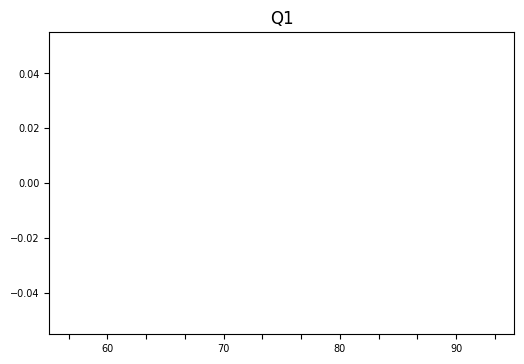

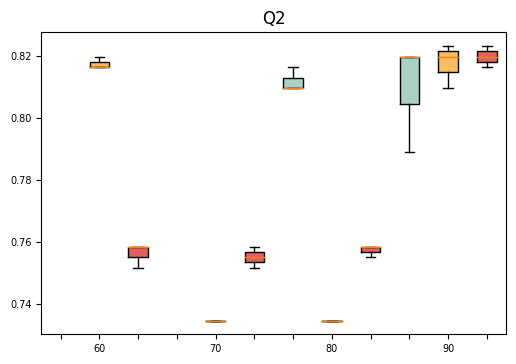

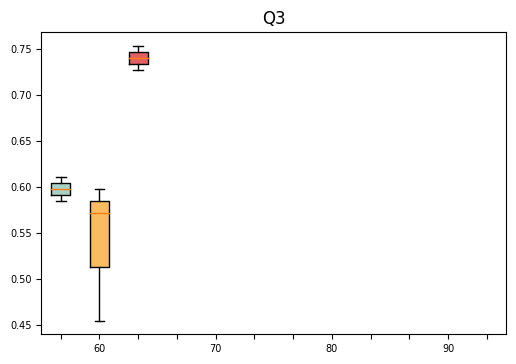

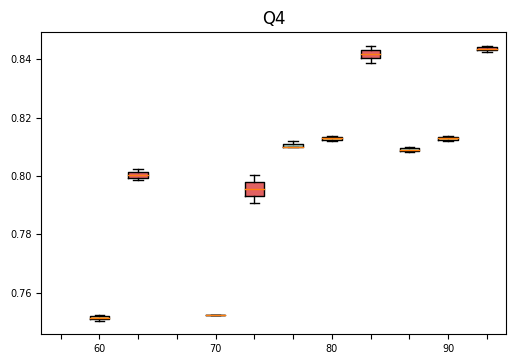

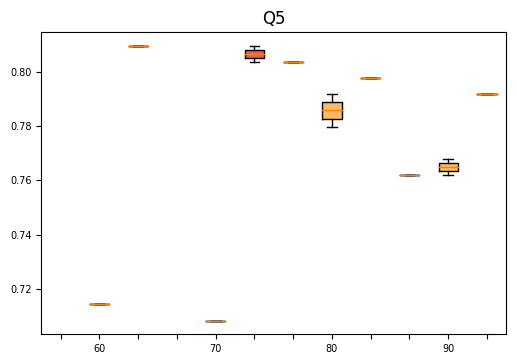

In [160]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['60','70','80','90']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

singleplot(constraint,y,Y,x_labels,df_result_ap,type='box')

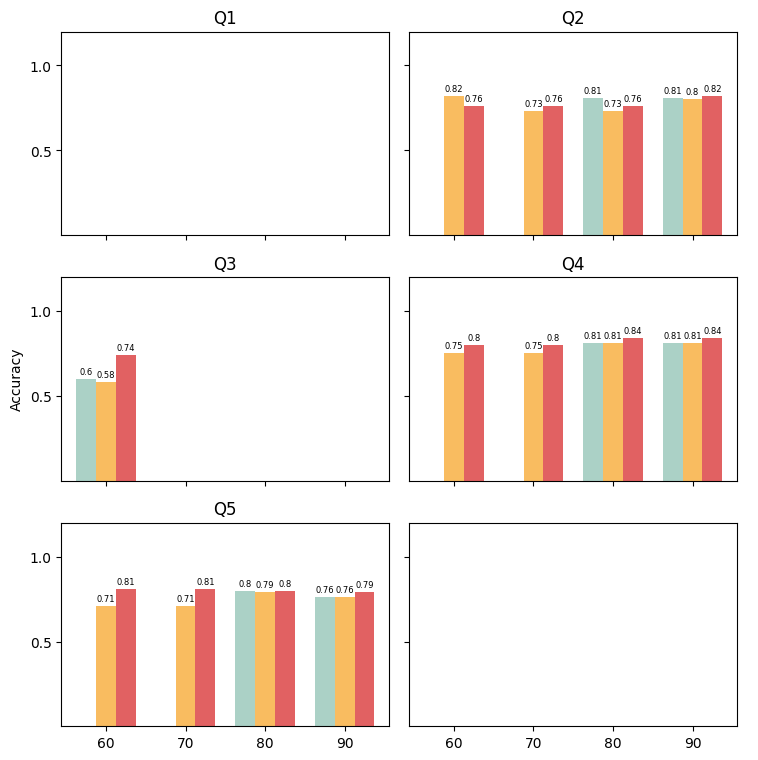

In [154]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['60','70','80','90']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

plot(constraint,y,Y,x_labels,df_result_ap,range(0,5),type='bar')

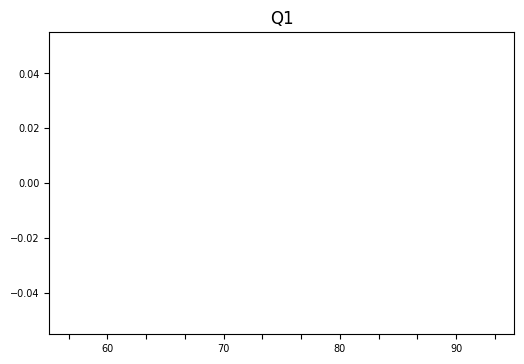

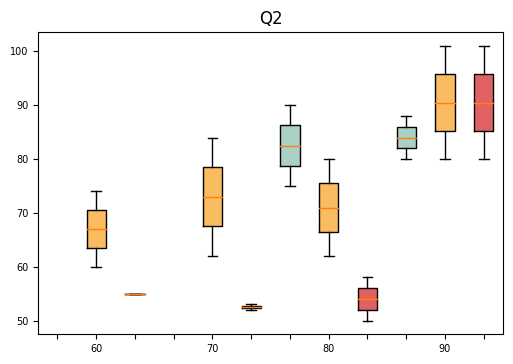

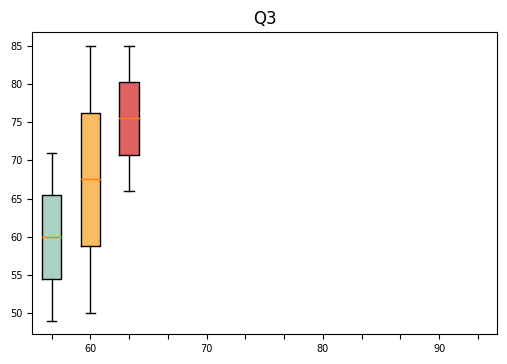

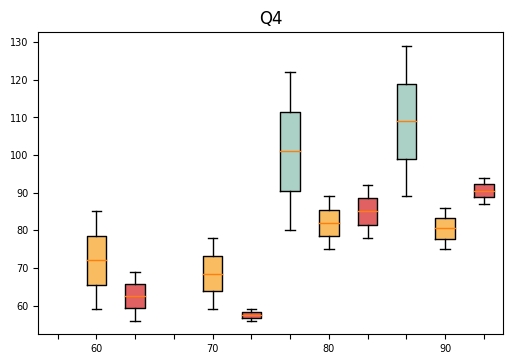

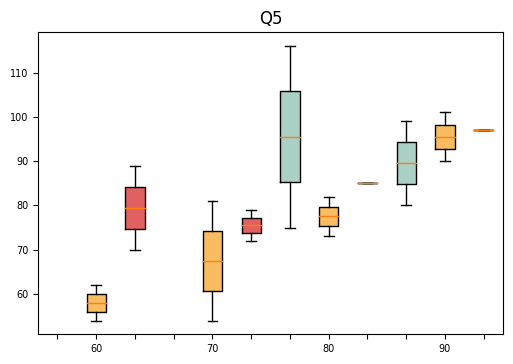

In [149]:
constraint = 'cost'
y = 'cost'
Y = 'Cost'
x_labels = ['60','70','80','90']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

singleplot(constraint,y,Y,x_labels,df_result_ap,type='box')

## Boundary

In [29]:
def oneColPlot(constraint,y,Y,x_labels,df_result,query_idx,type):
    ncols = 1
    f, axes = plt.subplots(nrows = len(query_idx), ncols = ncols, sharex=True, sharey = True,figsize=(8,8))
    for i,idx in enumerate(query_idx):
        if type == 'bar':
            subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint)]
            barplot(idx,subset,axes[i],x_labels,y,legend=False)
        elif type == 'box':
            subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint)]
            boxplot(idx,subset,axes[i],x_labels,y,legend=False)
        else:
            subset = [df[(df.query_index==idx) & (df.constraint==constraint)] for df in df_result]
            barplotCompare(idx,subset,axes[i],x_labels,y,legend=False)

    f.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.ylabel(Y)
    f.tight_layout()

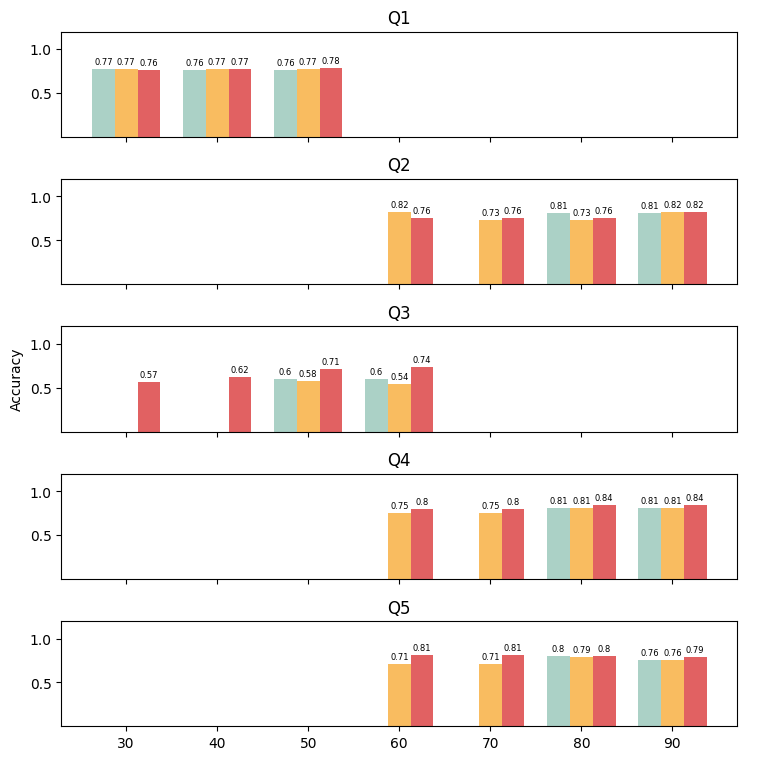

In [161]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
bound_range = range(30,100,10)
x_labels = list(map(str,bound_range))
# x_labels = ['50','100','150']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

oneColPlot(constraint,y,Y,x_labels,df_result_ap,range(0,5),type='bar')

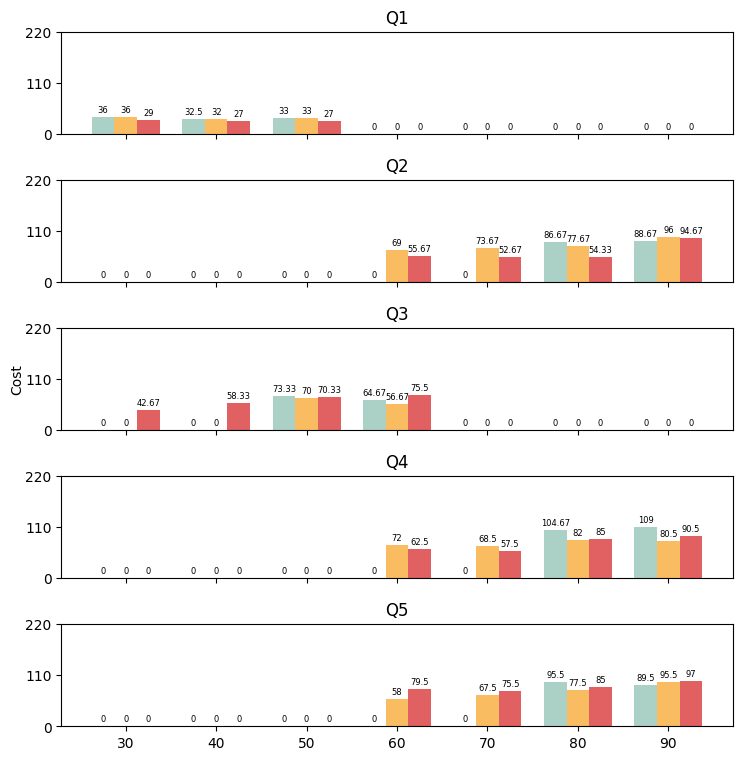

In [162]:
constraint = 'cost'
y = 'cost'
Y = 'Cost'
bound_range = range(30,100,10)
x_labels = list(map(str,bound_range))
# x_labels = ['50','100','150']
# x_labels = [50,100,150]

plt.rcParams['figure.dpi'] = 100

oneColPlot(constraint,y,Y,x_labels,df_result_ap,range(0,5),type='bar')

# Model assignment

In [49]:
# df_ = [df_baseline,df_opt,df_order_opt]
def printModelStats(query_range,bound,approach,pass_idx,df_record_dict,df_model,df_config):
    for idx in query_range:
        print('=============')
        print('query '+str(idx))
        for b in bound:
            for app in approach:
                print('***')
                print('bound',b)
                print('approach',app)
                print('***')
                df_record = df_record_dict[app]
                # print(df_record.head())
                
                subset = df_record[(df_record.query_index==idx) & (df_record['bound']==b)]
                
                print(subset['query'].values[pass_idx])
                print(subset['accuracy'].values[pass_idx])
                selected_model = subset.selected_model.values[pass_idx]
                
                if isinstance(selected_model,str):
                    assignment = {item.split('.')[0]:item.split('.')[1] for item in selected_model.split('|')}
                    print(assignment)
                    for k,v in assignment.items():
                        print('-----------')
                        print(k,v)
                        model_idx = int(re.search(r'\d+',v).group(0))
                        print('prop',round(df_config[df_config['index']==model_idx]['mis_prediction_prop'].values[0],3))
                        print('metric',df_model.loc[v,k])
                        print('cost',df_model.loc[v,'cost'])
                    print('*********')
                elif np.isnan(selected_model):
                    continue
                

In [50]:
df_record_list = getRecords('coco_ap_dnf_boundary','cost')
df_model = pd.read_csv('repository/model_stats_ap.csv',index_col=0)
df_config = pd.read_csv('repository/model_config_task_half_all.csv',index_col=0)

approaches = ['baseline','basic_opt','order_opt']
df_record_dict = {app:df_record_list[i] for i,app in enumerate(approaches)}

In [51]:
bound = [140]
approach = ['baseline','basic_opt','order_opt']
pass_idx = 0
query_range = range(3,4)

printModelStats(query_range,bound,approach,pass_idx,df_record_dict,df_model,df_config)

query 3
***
bound 140
approach baseline
***
bottle | (cup & bowl) | (person & chair)
0.888053225165
{'bottle': 'model_31', 'chair': 'model_31', 'person': 'model_40', 'cup': 'model_40', 'bowl': 'model_103'}
-----------
bottle model_31
prop 0.82
metric 0.5660000000000001
cost 48.0
-----------
chair model_31
prop 0.82
metric 0.615
cost 48.0
-----------
person model_40
prop 0.95
metric 0.922
cost 45.0
-----------
cup model_40
prop 0.95
metric 0.77
cost 45.0
-----------
bowl model_103
prop 0.808
metric 0.525
cost 47.0
*********
***
bound 140
approach basic_opt
***
bottle | (cup & bowl) | (person & chair)
0.975766048497664
{'bottle': 'model_133', 'bowl': 'model_133', 'cup': 'model_138', 'chair': 'model_138', 'person': 'model_138'}
-----------
bottle model_133
prop 0.992
metric 0.7440000000000001
cost 70.0
-----------
bowl model_133
prop 0.992
metric 0.784
cost 70.0
-----------
cup model_138
prop 0.967
metric 0.754
cost 64.0
-----------
chair model_138
prop 0.967
metric 0.8029999999999999
cos

In [ ]:
bound = [50,100,150]
approach = ['order_opt']
pass_idx = 0
query_range = range(1,2)

printModelStats(query_range,bound,approach,pass_idx,df_record_dict,df_model,df_config)

In [ ]:
path = 'output/'+'coco_half_order'+'/summary_order_'+constraint+'_optimizer.csv'
df_order_opt = pd.read_csv(path,index_col=0)
df_record_dict = {'order_opt':df_order_opt}

bound = [50,100,150]
approach = ['order_opt']
pass_idx = 0
query_range = range(4,5)


printModelStats(query_range,bound,approach,pass_idx,df_record_dict,df_model,df_config)

### Bar plot

In [23]:
def barplotCompare(idx,subset,ax,x_label,y,legend=False):
    
    labels = 'order_opt'
    
    subset_1, subset_2 = subset
    if y == 'accuracy':
        gt = subset_1[subset_1['objective_cost']==0]['accuracy'].max()
        ax.hlines(y=gt, xmin=-0.5, xmax=2.5, linewidth=1.5, color='r')
        
    
    v_order_1 = []
    v_order_2 = []
    for b in x_labels:
        try:
            v_order_1.append(round(np.mean(subset_1[(subset_1.approach==labels) & (subset_1.bound==b)][y].values),2))
        except: v_order_1.append(0)
        try:
            v_order_2.append(round(np.mean(subset_2[(subset_2.approach==labels) & (subset_2.bound==b)][y].values),2))
        except: v_order_2.append(0)
    
#     print(v_base,v_opt,v_order)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    
    rects1 = ax.bar(x - width, v_order_1, width, label=labels,color='#abd1c6')
    rects2 = ax.bar(x, v_order_2, width, label=labels,color='#f9bc60')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Accuracy')
    ax.set_title('Q'+str(idx+1))
    ax.set_xticks(x)
    if y == 'accuracy':
        ax.set_yticks([0.5, 1.0])
        ax.set_ylim([0,1.2])
    else:
        ax.set_yticks([0,110,220])
    ax.set_xticklabels(x_labels)
    if legend:
        ax.legend()

    ax.bar_label(rects1, padding=2,fontsize=6,label_type='edge')#edge
    ax.bar_label(rects2, padding=2,fontsize=6,label_type='edge')

In [26]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
# x_labels = ['50','100','150']
x_labels = [50,100,150]
plot(constraint,y,Y,x_labels,[df_result_half,df_result_half_order],type='compare')

NameError: name 'df_result_half' is not defined

In [24]:
import numpy as np

def barplot(idx,subset,ax,x_label,y,legend=False):
    
    if y == 'accuracy':
        gt = subset[subset['objective_cost']==0]['accuracy'].max()
        ax.hlines(y=gt, xmin=-0.5, xmax=2.5, linewidth=1.5, color='r')
    
    labels = ['baseline','basic_opt','order_opt']
    
    v_base = []
    v_opt = []
    v_order = []
    for b in x_labels:
        try:
            v_base.append(round(np.mean(subset[(subset.approach==labels[0]) & (subset.bound==b)][y].values),2))
        except: v_base.append(0)
        try:
            v_opt.append(round(np.mean(subset[(subset.approach==labels[1]) & (subset.bound==b)][y].values),2))
        except: v_opt.append(0)
        try:
            v_order.append(round(np.mean(subset[(subset.approach==labels[2]) & (subset.bound==b)][y].values),2))
        except: v_order.append(0)
    
#     print(v_base,v_opt,v_order)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    
    rects1 = ax.bar(x - width, v_base, width, label=labels[0],color='#abd1c6')
    rects2 = ax.bar(x, v_opt, width, label=labels[1],color='#f9bc60')
    rects3 = ax.bar(x + width, v_order, width, label=labels[2],color='#e16162')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Accuracy')
    ax.set_title('Q'+str(idx+1))
    ax.set_xticks(x)
    if y == 'accuracy':
        ax.set_yticks([0.5, 1.0])
        ax.set_ylim([0,1.2])
    else:
        ax.set_yticks([0,110,220])
    ax.set_xticklabels(x_labels)
    if legend:
        ax.legend()

    ax.bar_label(rects1, padding=2,fontsize=6,label_type='edge')#edge
    ax.bar_label(rects2, padding=2,fontsize=6,label_type='edge')
    ax.bar_label(rects3, padding=2,fontsize=6,label_type='edge')
    
#     ax.grid()


In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
# x_labels = ['50','100','150']
x_labels = [50,100,150]

plot(constraint,y,Y,x_labels,df_result_half,type='bar')

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']
# x_labels = [50,100,150]

plot(constraint,y,Y,x_labels,df_result_ignore_pareto_half,type='bar')

In [ ]:
constraint = 'cost'
y = 'cost'
Y = 'Cost'
x_labels = ['50','100','150']
# x_labels = [50,100,150]

plot(constraint,y,Y,x_labels,df_result_ignore_pareto_half,type='bar')

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']

plot(constraint,y,Y,x_labels,df_result_pareto,type='bar')

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']

plot(constraint,y,Y,x_labels,df_result_step,type='bar')

## Barplot seperate

In [ ]:
import numpy as np

def plotSep(constraint,y,Y,x_labels,df_result,type):
    ncols = 2
    for p in range(5):
        print('p = ',p)
        f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(8,10))
        for idx in range(5):
            subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) \
                               & (df_result['pass']==p)]
            if type == 'bar':
                barplot(idx,subset,axes[idx//ncols, idx%ncols],x_labels,y,legend=False)
            else:
                boxplot(idx,subset,axes[idx//ncols, idx%ncols],x_labels,y,legend=False)

        f.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.ylabel(Y)
        f.tight_layout()


In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']

plotSep(constraint,y,Y,x_labels,df_result_half,type='bar')

## Plot objectives vs. accu

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.dpi'] = 200

def scatter(df,ax,legend=False):
    
#     fig, ax = plt.subplots()
    for index,row in df.iterrows():
        ax.scatter(row.accu,row.objective_cost,label=row['approach'])
#     ax.xlabel("cost")
#     plt.ylabel('accuracy')
#     ax.set_ylim((0.5,1))
    if legend:
        ax.legend()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
import numpy as np

def barplot(idx,subset,ax,y,legend=False):

    labels = ['baseline','basic_opt','order_opt']
    objective = []
    real = []

    for l in labels:
        try:
            objective.append(round(subset[subset.approach==l]['objective_'+y].values[0],2))
        except: objective.append(0)
        try:
            real.append(round(subset[subset.approach==l][y].mean(),2))
        except: real.append(0)


    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    rects1 = ax.bar(x - width/2, objective, width, label=labels[0])
    ax.bar_label(rects1, padding=2,fontsize=6,label_type='edge')#edge
    

    rects2 = ax.bar(x + width/2, real, width, label=labels[1])
    ax.bar_label(rects2, padding=2,fontsize=6,label_type='edge')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Accuracy')
    ax.set_title('Q'+str(idx+1))
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=45)
                   
    if y == 'accuracy':
        ax.set_yticks([0.5, 1.0])
        ax.set_ylim([0,1.2])
    else:
        ax.set_yticks([0,220])
#         ax.set_ylim([0,int(max(objective+real)*1.5)])
#         ax.set_yticks([0,int(max(objective+real)*1.5)])
    
    if legend:
        ax.legend()

In [ ]:
constraint = 'cost'
bound = '50'
ncols = 4
df_result = df_result_pareto

f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))
for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    barplot(idx,subset,axes[idx//ncols, idx%ncols],y='accuracy',legend=False)

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Accuracy")

f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '50'
ncols = 4
df_result = df_result_pareto

f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))
for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    barplot(idx,subset,axes[idx//ncols, idx%ncols],y='cost',legend=False)

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Cost")

f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '50'
ncols = 4
df_result = df_result_44

f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(10):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='cost',legend=False)
    except:
        continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Cost")
f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '100'
ncols = 4
df_result = df_result_44

f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='accuracy',legend=False)
    except:continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Accuracy")
f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '100'
ncols = 4
df_result = df_result_complete

f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='accuracy',legend=False)
    except:continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Accuracy")
f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '100'
ncols = 4
f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='cost',legend=False)
    except:continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Cost")
f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '150'
ncols = 4
df_result = df_result_44
f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='accuracy',legend=False)
    except:continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Accuracy")
f.tight_layout()

In [ ]:
constraint = 'cost'
bound = '150'
ncols = 4
df_result = df_result_complete
f, axes = plt.subplots(nrows = 3, ncols = ncols, sharex=True, sharey = True,figsize=(9,6))

for idx in range(11):
#     print(idx)
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    try:
        barplot(idx,subset,axes[idx//ncols, idx%ncols],y='accuracy',legend=False)
    except:continue

f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel("Accuracy")
f.tight_layout()

## Effect of constraints

In [ ]:
constraint = 'cost'
y = 'accuracy'
Y = 'Accuracy'
x_labels = ['50','100','150']

plot(constraint,y,Y,x_labels,df_result_44_30)

In [ ]:
constraint = 'cost'
y='cost'
Y='Cost'
x_labels = ['50','100','150']

plot(constraint,y,Y,x_labels,df_result_complete)

## Model assignment

In [ ]:
bound = 50
approach = ['baseline','basic_opt','order_opt']
# df_ = [df_baseline,df_opt,df_order_opt]

for idx in range(3,4):
    print('=============')
    print('query '+str(idx))
    if idx == 1: continue
    for i,app in enumerate(approach):
        print('***')
        print(app)
        print('***')
        df_record = df_record_list[i]
        subset = df_record[(df_record.query_index==idx) & (df_record['bound']==bound)]
        print(subset['query'].values[0])
        print(subset['accuracy'].values[0])
        selected_model = subset.selected_model.values[1]
        assignment = {item.split('.')[0].replace('_',' '):item.split('.')[1] for item in selected_model.split('|')}
        print(assignment)
        for k,v in assignment.items():
            print(k,v)
            print(df_model.loc[v,k])
        print('---------')

## Cost = 100

In [ ]:
import glob
import re
import pandas as pd
from sympy.parsing.sympy_parser import parse_expr

constraint = 'cost'

df_result_100 = pd.DataFrame(columns=['name','query_index','query','constraint','bound',\
                                  'len','accuracy','cost','total_cost','objective_accuracy','objective_cost','result_index'])

In [ ]:
folder = 'tables/'
for file in glob.glob(folder+"*"):
    print(file)
    df = pd.read_csv(file)
    print(df.shape)
    
    name = file.split('/')[-1].split('.')[0]
    print('name',name)
    if len(name.split('_')) < 4:
        continue

    if not df_result_100[df_result_100['name'] == name].empty:
        continue
    
    # retrieve cost
    total_cost = df_cost[(df_cost['experiment']=='script_'+name) & (df_cost['duration']>10)]['duration'].sum()/5
#     cost = df_cost[(df_cost['experiment']=='script_'+name)]['duration'][::-2].sum()-10
    subset = df_cost[(df_cost['experiment']=='script_'+name)]
    s = list(subset.sort_values(by=['startedAt'])['duration'][2:]) # [2,3,::2]
    
#     cost = sum([s[0]]+s[1:][::2]) / 5
    cost = total_cost
    print('cost',cost)

    order = name.split('_')[2] == 'order'
    print('order',order)
    
    query_idx = int(re.search(r'\d+', name).group(0))
    print(query_idx)
    
    consr_type = re.search(r'.*_([a-z]+)_.*', name).group(1)
    if consr_type != constraint:
        continue
        
    bound = re.search(r'.*_(\d+)', name).group(1)
    query = queryList[query_idx]
    
    if order:
        df_record = df_order_opt
        approach = 'order_opt'
    elif name[:3] == 'opt':
        df_record = df_opt
        approach = 'basic_opt'
    else:
        df_record = df_baseline
        approach = 'baseline'
        
    # Match objective value with extracted accuracy results
    record = df_record[(df_record['query_index']==query_idx) & (df_record['constraint']==consr_type)]
    
    index = getImageIndex(query,df)
    gt = list(filter(lambda x: x>=2000, indexList[query_idx]))
    label = list(filter(lambda x: x>=2000,index))
    intersection = list(set.intersection(set(gt), set(label)))
    
    print('intersect',len(intersection))
    print('total',len(gt))
    
    accu = len(intersection)/len(gt)
    print('accu',accu)
    result_idx = ','.join([str(i) for i in index])

    new_row = pd.DataFrame([{'name':name,'query_index':query_idx,'query':query,\
                             'constraint':constraint,'bound':bound,'approach':approach,'len':len(index),\
                             'accuracy':round(accu,4),'cost':cost,'total_cost':total_cost,'objective_accuracy':round(record.accuracy.values[0],4),\
                             'objective_cost':int(record['cost'].values[0]),'result_index':result_idx}])
#     print(new_row)
    df_result_100 = df_result_100.append(new_row, ignore_index=True)
    
    print('----------')
    print()
    

In [ ]:
folder = 'tables/'

for file in glob.glob(folder+'yolov*.csv'):
    
    df = pd.read_csv(file)

    name = file.split('/')[-1].split('.')[0]
    print('name',name)

    # retrieve cost
    cost = df_cost[(df_cost['experiment']=='script_'+name) & (df_cost['duration']>10)]['duration'].sum()
    cost = cost / 5
    print('cost',cost)

    for i in range(4):
        query = queryList[i]
        index = getImageIndex(query,df)
        gt = list(filter(lambda x: x>=2000, indexList[i]))
        label = list(filter(lambda x: x>=2000,index))
        intersection = list(set.intersection(set(gt), set(label)))
        print('intersect',len(intersection))
        print('total',len(gt))
        accu = len(intersection)/len(gt)
        print('accu',accu)
        result_idx = ','.join([str(i) for i in index])

        new_row = pd.DataFrame([{'name':name,'query_index':i,'query':query,\
                                 'constraint':'cost','bound':bound,'approach':'gt','len':len(index),\
                                 'accuracy':round(accu,4),'cost':cost,'objective_accuracy':1.0,\
                                 'objective_cost':0,'result_index':result_idx}])
    #     print(new_row)
        df_result_100 = df_result_100.append(new_row, ignore_index=True)

        print('----------')
        print()

## Plot accu vs. cost

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.dpi'] = 200

def scatter(idx,df,ax,legend=False):
    
    gt = df[df['objective_cost']==0]['accuracy'].max()
    ax.hlines(y=gt, xmin=0, xmax=200, linewidth=1.5, color='r')
    
    labels = ['baseline','basic_opt','order_opt']
    objective = []
    real = []
    for l in labels:
        row = df[df.approach==l]
        ax.scatter(row.cost.values[0],row.accuracy.values[0],label=l)
    
    ax.set_xticks([0,100,200])
    ax.set_xticklabels([0,100,200],fontsize=11)
#     ax.set_yticks([0.5, 0.75, 1.0])
    ax.set_title('Q'+str(idx+1))
#     ax.set_ylim((0.5,1))
    if legend:
        ax.legend()
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
constraint = 'cost'
bound = '150'
ncols = 2
f, axes = plt.subplots(nrows = 2, ncols = ncols, sharex=True, sharey = True,figsize=(9,5))
# plt.setp(axes, xticks=[0.1, 0.5, 1.2],yticks=[128,170,220])

for idx in range(3):
    subset = df_result[(df_result.query_index==idx) & (df_result.constraint==constraint) & (df_result.bound==bound)]
    scatter(idx,subset,axes[idx//ncols, idx%ncols],legend=True)
    
f.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Cost")
plt.ylabel("Accuracy")
f.tight_layout()

## Retrieve task name

In [ ]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', \
			'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', \
			'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', \
			'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', \
			'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', \
			'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', \
			'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', \
			'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', \
			'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', \
			'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'toothbrush']

In [ ]:
len(names)

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer','order_opt']


def load_cost(m_dist,q_dist,approach):
    filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
    if approach == 'order_opt':
        filepath = 'output/summary_order_cost_'+m_dist+'_'+q_dist+'_optimizer.csv'
    try:
        df = pd.read_csv(filepath,index_col=0)
    except Exception as e:
        filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'_a=5.csv'
        df = pd.read_csv(filepath,index_col=0)
        
    print(df.shape)
#     print(df.head())
    return df

df_list = []
label_list = []
for q in q_dist:
    for m in m_dist:
        for app in approach:
            df_list.append(load_cost(m,q,app))
            if app == 'baseline_pareto':
                app = 'baseline'
            label_list.append(app+'_'+m+'_'+q)
print(label_list)

In [ ]:
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()

for i in range(len(df_list)):
    ax.scatter(df_list[i]['cost'], df_list[i]['accuracy'],label=label_list[i])

plt.ylabel('Accuracy')
plt.xlabel('Cost')
plt.title('Performance of query results when cost is constrained')
plt.legend()

In [ ]:
# q_dist = ['uniform','power_law']
# m_dist = q_dist
# approach = ['baseline_pareto','optimizer']


# def load_cost(m_dist,q_dist,approach):
#     filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
#     try:
#         df = pd.read_csv(filepath,index_col=0)
#     except Exception as e:
#         filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'_a=5.csv'
#         df = pd.read_csv(filepath,index_col=0)

#     print(df.shape)
# #     print(df.head())
#     return df

# df_list = []
# label_list = []
# for q in q_dist:
#     for m in m_dist:
#         for app in approach:
#             df_list.append(load_cost(m,q,app))
#             if app == 'baseline_pareto':
#                 app = 'baseline'
#             label_list.append(app+'_'+m+'_'+q)
# print(label_list)

In [ ]:
# plt.rcParams['figure.dpi'] = 100
# fig, ax = plt.subplots()

# for i in range(len(df_list)):
#     ax.scatter(df_list[i]['cost'], df_list[i]['accuracy'],label=label_list[i])

# plt.ylabel('Accuracy')
# plt.xlabel('Cost')
# plt.title('Performance of query results when cost is constrained')
# # plt.yscale('logit')
# plt.legend()

### Boxplot on the objective dimension: accuracy

In [ ]:
def boxplot(com_dists,data,max_y=0,ylabel='Accuracy',constraint='Cost',size=14,path='',x_offset=0,y_offset=0):
    fig, ax1 = plt.subplots(figsize=(7, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
#         title=ylabel+' of query results when '+constraint+' is constrained',
        xlabel='Combinations (m_dist:q_dist)',
        ylabel=ylabel,
    )
    ax1.xaxis.get_label().set_fontsize(size)
    ax1.yaxis.get_label().set_fontsize(size)

    # Now fill the boxes with desired colors
    box_colors = ['#2694ab', '#e59572']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    means = [np.mean(x) for x in data]
#     print(means)
    # pylab.scatter(range(1,len(data)+1), means)

    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='X', markeredgecolor='k',markersize=10)

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = max_y * 1.1
    bottom = 0
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(np.repeat(comb_dists, 2),
                        rotation=45, fontsize=size)
    ax1.tick_params(labelsize=size)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    # upper_labels = [str(round(s, 2)) for s in medians]
    upper_labels = [str(round(s, 3)) for i,s in enumerate(means)]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='medium',
                 weight=weights[k], color=box_colors[k])
    # Valid font size are xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None
    # Finally, add a basic legend
    fig.text(0.79-x_offset, 0.461-y_offset, 'Baseline',
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.417-y_offset, 'Optimizer',
             backgroundcolor=box_colors[1],
             color='white', weight='roman', size='medium')
    fig.text(0.79-x_offset, 0.374-y_offset, 'x', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.81-x_offset, 0.374-y_offset, ' Avg.', color='black', weight='roman',
             size='medium')
    plt.tight_layout()
    
    plt.savefig(path,format='eps')

    plt.show()

In [ ]:
comb_dists = []
data = []
i=0
for q in q_dist:
    for m in m_dist:
        comb_dists.append(m+':'+q)
        for app in approach:
            data.append(df_list[i]['accuracy'])
            i+=1
print(comb_dists)
ylabel='Accuracy'
constraint='cost'
print(ylabel+' of query results when '+constraint+' is constrained')
boxplot(comb_dists,data,max_y=max(data[0]),
        ylabel='Accuracy',constraint='cost',
       path="image/accuacy_vs_approaches_constraint_cost.eps")


## Boxplot two optimizer

In [ ]:
def boxplot(com_dists,data,max_y=0,ylabel='Accuracy',constraint='Cost',size=14,path='',x_offset=0,y_offset=0):
    fig, ax1 = plt.subplots(figsize=(9, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
#         title=ylabel+' of query results when '+constraint+' is constrained',
        xlabel='Combinations (m_dist:q_dist)',
        ylabel=ylabel,
    )
    ax1.xaxis.get_label().set_fontsize(size)
    ax1.yaxis.get_label().set_fontsize(size)

    # Now fill the boxes with desired colors
    box_colors = ['#2694ab', '#e59572','#e16162']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    means = [np.mean(x) for x in data]
#     print(means)
    # pylab.scatter(range(1,len(data)+1), means)
    print('num_boxes',num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
#         print(box.get_xdata())
#         print(box.get_ydata())
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 3]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='X', markeredgecolor='k',markersize=10)

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = max_y * 1.03
    bottom = 0.7
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(np.repeat(comb_dists, 3),
                        rotation=45, fontsize=size)
    ax1.tick_params(labelsize=size)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    # upper_labels = [str(round(s, 2)) for s in medians]
    upper_labels = [str(round(s, 3)) for i,s in enumerate(means)]
    weights = ['bold', 'semibold','semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 3
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='medium',
                 weight=weights[k], color=box_colors[k])
    # Valid font size are xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None
    # Finally, add a basic legend
    fig.text(0.79-x_offset, 0.5-y_offset, 'Baseline',
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.461-y_offset, 'Optimizer',
             backgroundcolor=box_colors[1], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.417-y_offset, 'Order_Opt',
             backgroundcolor=box_colors[2],
             color='white', weight='roman', size='medium')
    fig.text(0.79-x_offset, 0.374-y_offset, 'x', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.81-x_offset, 0.374-y_offset, ' Avg.', color='black', weight='roman',
             size='medium')
    plt.tight_layout()
    
    plt.savefig(path,format='eps')

    plt.show()

In [ ]:
comb_dists = []
data = []
i=0
for q in q_dist:
    for m in m_dist:
        comb_dists.append(m+':'+q)
        for app in approach:
            data.append(df_list[i]['accuracy'])
            i+=1
print(comb_dists)
ylabel='Accuracy'
constraint='cost'
print(ylabel+' of query results when '+constraint+' is constrained')
boxplot(comb_dists,data,max_y=max(data[0]),
        ylabel='Accuracy',constraint='cost',
       path="image/accuacy_vs_approaches_constraint_cost.eps")

## Pareto

In [ ]:
def boxplot(com_dists,data,max_y=0,ylabel='Accuracy',constraint='Cost',size=14,path='',x_offset=0,y_offset=0):
    fig, ax1 = plt.subplots(figsize=(9, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
#         title=ylabel+' of query results when '+constraint+' is constrained',
        xlabel='Combinations (m_dist:q_dist)',
        ylabel=ylabel,
    )
    ax1.xaxis.get_label().set_fontsize(size)
    ax1.yaxis.get_label().set_fontsize(size)

    # Now fill the boxes with desired colors
    box_colors = ['#2694ab', '#e59572','#e16162']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    means = [np.mean(x) for x in data]
#     print(means)
    # pylab.scatter(range(1,len(data)+1), means)
    print('num_boxes',num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
#         print(box.get_xdata())
#         print(box.get_ydata())
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 3]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='X', markeredgecolor='k',markersize=10)

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = max_y * 1.1
    bottom = 0
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(np.repeat(comb_dists, 3),
                        rotation=45, fontsize=size)
    ax1.tick_params(labelsize=size)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    # upper_labels = [str(round(s, 2)) for s in medians]
    upper_labels = [str(round(s, 3)) for i,s in enumerate(means)]
    weights = ['bold', 'semibold','semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 3
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='medium',
                 weight=weights[k], color=box_colors[k])
    # Valid font size are xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None
    # Finally, add a basic legend
    fig.text(0.89-x_offset, 0.8-y_offset, 'Baseline',
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='medium')
    fig.text(0.89-x_offset, 0.761-y_offset, 'Optimizer',
             backgroundcolor=box_colors[1], color='white', weight='roman',
             size='medium')
    fig.text(0.89-x_offset, 0.717-y_offset, 'Order_Opt',
             backgroundcolor=box_colors[2],
             color='white', weight='roman', size='medium')
    fig.text(0.89-x_offset, 0.674-y_offset, 'x', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.91-x_offset, 0.674-y_offset, ' Avg.', color='black', weight='roman',
             size='medium')
    plt.tight_layout()
    
    plt.savefig(path,format='eps')

    plt.show()

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer','order_opt']

comb_dists = []
data = []
i = 0
for q in q_dist:
    for m in m_dist:
        comb_dists.append(m+':'+q)
        for app in approach:
            data.append(df_list[i]['pareto_ratio'])
            i+=1
print(comb_dists)

boxplot(comb_dists,data,max_y=max([max(x) for x in data]),
        ylabel='Pareto ratio',constraint='cost', x_offset=0.06,
       path='image/pareto_vs_approaches_constraint_cost.eps')

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer']


comb_dists = []
data = []
i=0

for a,app in enumerate(approach):
    for i,m in enumerate(m_dist):
        for j,q in enumerate(q_dist):
            if app == 'baseline_pareto':
                app = 'baseline'
            comb_dists.append(app+'-'+m+':'+q)
            data.append(df_list[4*i+2*j+a][['#predicate','optimization_time']])
print(comb_dists)

In [ ]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 200
df = pd.DataFrame(columns=['#predicate','approach','optimization_time'])

for i,d in enumerate(data):
    d.loc[d['#predicate']==15,'#predicate']= 16
    d.loc[30-d['#predicate']<5,'#predicate'] = 32
    d['approach'] = [comb_dists[i]]*len(d)
    df = df.append(d,ignore_index=True)

    
# dd=pd.melt(df,id_vars=['#predicate'],value_vars=['Apple','Orange'],var_name='fruits')
g = sns.boxplot(x='#predicate',y='optimization_time',data=df,hue='approach')
# g.set_title("Runtime against #predicate in a query when constrained on cost",fontsize=8)
# plt.legend(bbox_to_anchor=(0.9, 0.8))
g.legend(loc='upper center', bbox_to_anchor=(0.45, 1.45),
          ncol=2, fancybox=True, shadow=True,prop={'size': 9})
g.set_yscale("log")
g.tick_params(labelsize=11)
g.xaxis.get_label().set_fontsize(11)
g.yaxis.get_label().set_fontsize(11)
plt.tight_layout()
plt.savefig('image/runtime_vs_approaches_constraint_cost.eps',format='eps')

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer']

comb_dists = []
data = []
i=0
for m in m_dist:
    for q in q_dist:
        comb_dists.append(m+':'+q)
        data.append(df_list[i*2+1][['#predicate','optimization_time']])
        i+=1
print(comb_dists)

In [ ]:
plt.rcParams['figure.dpi'] = 200
df = pd.DataFrame(columns=['#predicate','optimizer','optimization_time'])

for i,d in enumerate(data):
    d.loc[d['#predicate']==15,'#predicate']= 16
    d.loc[30-d['#predicate']<5,'#predicate'] = 32
    d['optimizer'] = [comb_dists[i]]*len(d)
    df = df.append(d,ignore_index=True)

# dd=pd.melt(df,id_vars=['#predicate'],value_vars=['Apple','Orange'],var_name='fruits')
g = sns.boxplot(x='#predicate',y='optimization_time',data=df,hue='optimizer')
# g.set_title("Runtime against #predicate in a query when constrained on cost",fontsize=8)
g.legend(loc='upper center', bbox_to_anchor=(0.6, 0.2),
          ncol=2, fancybox=True, shadow=True,prop={'size': 9})
g.set_yscale("log")

g.tick_params(labelsize=11)
g.xaxis.get_label().set_fontsize(11)
g.yaxis.get_label().set_fontsize(11)
plt.tight_layout()
plt.savefig('image/runtime_vs_optimizers_constraint_cost.eps',format='eps')

In [ ]:
q_dist = ['uniform']
m_dist = q_dist
approach = ['baseline_pareto','optimizer']

def load(m_dist,q_dist,approach):
    filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
    df = pd.read_csv(filepath,index_col=0)
#     print(df.head())
    return df[['#predicate','optimization_time']]

comb_dists = []
data = []
i=0
for m in m_dist:
    for q in q_dist:
        for app in approach:
            comb_dists.append(app)
            data.append(df_list[i][['#predicate','optimization_time']])
            i+=1
print(comb_dists)

plt.rcParams['figure.dpi'] = 200
df = pd.DataFrame(columns=['#predicate','approach','optimization_time'])

for i,d in enumerate(data):
    d.loc[d['#predicate']==15,'#predicate']= 16
    d.loc[30-d['#predicate']<5,'#predicate'] = 32
    d['approach'] = [comb_dists[i]]*len(d)
    df = df.append(d,ignore_index=True)
    
print(df.shape)
print(df.head())
    
# dd=pd.melt(df,id_vars=['#predicate'],value_vars=['Apple','Orange'],var_name='fruits')
g = sns.boxplot(x='#predicate',y='optimization_time',data=df,hue='approach')
g.set_title("Runtime against #predicate in a query when constrained on cost",fontsize=8)
g.set_yscale("log")

## Constraint on accuracy, minmize cost

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer']


def load_accu(m_dist,q_dist,approach):
    filepath = 'output/summary_accuracy_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
    df = pd.read_csv(filepath,index_col=0)
    print(df.shape)
#     print(df.head())
    return df

df_list = []
label_list = []
for q in q_dist:
    for m in m_dist:
        for app in approach:
            df_list.append(load_accu(m,q,app))
            label_list.append(app+'_'+m+'_'+q)
print(label_list)

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer','order_opt']


def load_cost(m_dist,q_dist,approach):
    filepath = 'output/summary_accuracy_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
    if approach == 'order_opt':
        filepath = 'output/summary_order_accuracy_'+m_dist+'_'+q_dist+'_optimizer.csv'
    try:
        df = pd.read_csv(filepath,index_col=0)
    except Exception as e:
        filepath = 'output/summary_cost_'+m_dist+'_'+q_dist+'_'+approach+'_a=5.csv'
        df = pd.read_csv(filepath,index_col=0)
        
    print(df.shape)
#     print(df.head())
    return df

df_list = []
label_list = []
for q in q_dist:
    for m in m_dist:
        for app in approach:
            df_list.append(load_cost(m,q,app))
            if app == 'baseline_pareto':
                app = 'baseline'
            label_list.append(app+'_'+m+'_'+q)
print(label_list)

In [ ]:
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()

for i in range(len(df_list)):
    ax.scatter(df_list[i]['cost'], df_list[i]['accuracy'],label=label_list[i])

plt.ylabel('Accuracy')
plt.xlabel('Cost')
# plt.yscale('logit')
plt.legend()

In [ ]:
def boxplot(com_dists,data,max_y=0,ylabel='Accuracy',constraint='Cost',size=14,path='',x_offset=0,y_offset=0):
    fig, ax1 = plt.subplots(figsize=(9, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
#         title=ylabel+' of query results when '+constraint+' is constrained',
        xlabel='Combinations (m_dist:q_dist)',
        ylabel=ylabel,
    )
    ax1.xaxis.get_label().set_fontsize(size)
    ax1.yaxis.get_label().set_fontsize(size)

    # Now fill the boxes with desired colors
    box_colors = ['#2694ab', '#e59572','#e16162']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    means = [np.mean(x) for x in data]
#     print(means)
    # pylab.scatter(range(1,len(data)+1), means)
    print('num_boxes',num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
#         print(box.get_xdata())
#         print(box.get_ydata())
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 3]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='X', markeredgecolor='k',markersize=10)

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = max_y * 0.2
    bottom = 0
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(np.repeat(comb_dists, 3),
                        rotation=45, fontsize=size)
    ax1.tick_params(labelsize=size)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    # upper_labels = [str(round(s, 2)) for s in medians]
    upper_labels = [str(round(s, 3)) for i,s in enumerate(means)]
    weights = ['bold', 'semibold','semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 3
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='medium',
                 weight=weights[k], color=box_colors[k])
    # Valid font size are xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None
    # Finally, add a basic legend
#     ax1.set_yscale('log')
    fig.text(0.79-x_offset, 0.5-y_offset, 'Baseline   ',
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.461-y_offset, 'Optimizer ',
             backgroundcolor=box_colors[1], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.417-y_offset, 'Order_Opt',
             backgroundcolor=box_colors[2],
             color='white', weight='roman', size='medium')
    fig.text(0.79-x_offset, 0.374-y_offset, 'x', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.81-x_offset, 0.374-y_offset, ' Avg.', color='black', weight='roman',
             size='medium')
    plt.tight_layout()
    
    plt.savefig(path,format='eps')

    plt.show()

In [ ]:

comb_dists = []
data = []
i=0
for q in q_dist:
    for m in m_dist:
        comb_dists.append(m+':'+q)
        for app in approach:
            data.append(df_list[i]['cost'])
            i+=1
print(comb_dists)

boxplot(comb_dists,data,max_y=max([max(x) for x in data]),
        ylabel='Cost',constraint='accuracy',
       path='image/cost_vs_approaches_constraint_accu.eps',
       y_offset=-0.2)

## Pareto ratio

In [ ]:
def boxplot(com_dists,data,max_y=0,ylabel='Accuracy',constraint='Cost',size=14,path='',x_offset=0,y_offset=0):
    fig, ax1 = plt.subplots(figsize=(9, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
#         title=ylabel+' of query results when '+constraint+' is constrained',
        xlabel='Combinations (m_dist:q_dist)',
        ylabel=ylabel,
    )
    ax1.xaxis.get_label().set_fontsize(size)
    ax1.yaxis.get_label().set_fontsize(size)

    # Now fill the boxes with desired colors
    box_colors = ['#2694ab', '#e59572','#e16162']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    means = [np.mean(x) for x in data]
#     print(means)
    # pylab.scatter(range(1,len(data)+1), means)
    print('num_boxes',num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
#         print(box.get_xdata())
#         print(box.get_ydata())
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 3]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='X', markeredgecolor='k',markersize=10)

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = max_y * 1.1
    bottom = 0
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(np.repeat(comb_dists, 3),
                        rotation=45, fontsize=size)
    ax1.tick_params(labelsize=size)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    # upper_labels = [str(round(s, 2)) for s in medians]
    upper_labels = [str(round(s, 3)) for i,s in enumerate(means)]
    weights = ['bold', 'semibold','semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 3
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='medium',
                 weight=weights[k], color=box_colors[k])
    # Valid font size are xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None
    # Finally, add a basic legend
    fig.text(0.79-x_offset, 0.5-y_offset, 'Baseline',
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.461-y_offset, 'Optimizer',
             backgroundcolor=box_colors[1], color='white', weight='roman',
             size='medium')
    fig.text(0.79-x_offset, 0.417-y_offset, 'Order_Opt',
             backgroundcolor=box_colors[2],
             color='white', weight='roman', size='medium')
    fig.text(0.79-x_offset, 0.374-y_offset, 'x', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.81-x_offset, 0.374-y_offset, ' Avg.', color='black', weight='roman',
             size='medium')
    plt.tight_layout()
    
    plt.savefig(path,format='eps')

    plt.show()

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist
approach = ['baseline_pareto','optimizer','order_opt']


comb_dists = []
data = []
i=0
for q in q_dist:
    for m in m_dist:
        comb_dists.append(m+':'+q)
        for app in approach:
            data.append(df_list[i]['pareto_ratio'])
            i+=1
print(comb_dists)

boxplot(comb_dists,data,max_y=max([max(x) for x in data]),
        ylabel='Pareto ratio',constraint='cost',
        path='image/pareto_vs_approaches_constraint_cost.eps',
       x_offset=0.07)

### Runtime

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist

def load(m_dist,q_dist,approach):
    filepath = 'repository/run_summary_accuracy_'+m_dist+'_'+q_dist+'_'+approach+'.csv'
    df = pd.read_csv(filepath,index_col=0)
#     print(df.head())
    return df[['#predicate','optimization_time']]

comb_dists = []
data = []
i=0
for m in m_dist:
    for q in q_dist:
        comb_dists.append(m+':'+q)
        data.append(df_list[i*2+1][['#predicate','optimization_time']])
        i+=1
print(comb_dists)


In [ ]:
plt.rcParams['figure.dpi'] = 200
df = pd.DataFrame(columns=['#predicate','optimizer','optimization_time'])

for i,d in enumerate(data):
    d.loc[d['#predicate']==15,'#predicate']= 16
    d.loc[30-d['#predicate']<5,'#predicate'] = 32
    d['optimizer'] = [comb_dists[i]]*len(d)
    df = df.append(d,ignore_index=True)

# dd=pd.melt(df,id_vars=['#predicate'],value_vars=['Apple','Orange'],var_name='fruits')
g = sns.boxplot(x='#predicate',y='optimization_time',data=df,hue='optimizer')
# g.set_title("Runtime against #predicate in a query when constrained on accuarcy",fontsize=8)
g.set_yscale("log")
g.legend(loc='upper center', bbox_to_anchor=(0.6, 0.2),
          ncol=2, fancybox=True, shadow=True,prop={'size': 9})
g.set_yscale("log")

g.tick_params(labelsize=11)
g.xaxis.get_label().set_fontsize(11)
g.yaxis.get_label().set_fontsize(11)
plt.tight_layout()
plt.savefig('image/runtime_vs_optimizers_constraint_accu.eps',format='eps')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_optimizer,_optimizer['pareto_ratio'],label='optimizer')
ax.scatter(x_mix_optimizer,mix_optimizer['pareto_ratio'],label='optimizer-mix')
ax.scatter(x_uni_mix_optimizer,uni_mix_optimizer['pareto_ratio'],label='optimizer-uni-mix')
ax.scatter(x_pow_optimizer,pow_optimizer['pareto_ratio'],label='optimizer-pow')

# rectangular box plot
bplot1 = ax.boxplot([_optimizer[_optimizer['#predicate']==k]['pareto_ratio'] for k in [2,4,8,16,32]],
                     showfliers=False,
                     vert=True,  # vertical box alignment
                     labels=range(5)) 
c1 = "blue"
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bplot1[item], color=c1)

bplot1 = ax.boxplot([mix_optimizer[mix_optimizer['#predicate']==k]['pareto_ratio'] for k in [2,4,8,16,32]],
                     showfliers=False,
                     vert=True,  # vertical box alignment
                     labels=range(5)) 
c2 = "orange"
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bplot1[item], color=c2)
    
# bplot1 = ax.boxplot([x_uni_mix_optimizer[x_uni_mix_optimizer['#predicate']==k]['pareto_ratio'] for k in [2,4,8,16,32]],
#                      showfliers=False,
#                      vert=True,  # vertical box alignment
#                      labels=range(5)) 

# c2 = "orange"
# for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
#     plt.setp(bplot1[item], color=c2)
    
plt.xticks(range(1,6),key)
plt.ylabel('Pareto ratio')
plt.xlabel('#predicate')
plt.legend()

In [ ]:
def boxplot(data,query_range):
    box_colors = ['darkkhaki', 'royalblue']
    fig, ax = plt.subplots()
    ax.set_title('Pareto Ratio')
    bp = ax.boxplot(data)
    plt.xticks(range(1,len(query_range)+1), query_range)
    plt.xlabel("#queries")
    plt.ylabel("Pareto ratio")
    plt.show()

## Runtime

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_baseline, _baseline['runtime'],label='baseline')
ax.scatter(x_optimizer,_optimizer['pareto_ratio'],c='orange',label='optimizer')
# rectangular box plot
bplot1 = ax.boxplot([_baseline[_baseline['#predicate']==k]['pareto_ratio'] for k in key],
                     notch=True,
                     vert=True,  # vertical box alignment
                     showfliers=False,
                     labels=range(5))  # will be used to label x-ticks
c1 = "blue"
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bplot1[item], color=c1)

bplot1 = ax.boxplot([_optimizer[_optimizer['#predicate']==k]['pareto_ratio'] for k in key],
                     showfliers=False,
                     vert=True,  # vertical box alignment
                     labels=range(5)) 
c2 = "orange"
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bplot1[item], color=c2)
plt.xticks(range(1,6),key)
plt.ylabel('Pareto ratio')
plt.xlabel('#predicate')
plt.legend()

## YOLOV3 converted performance

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pandas.plotting import andrews_curves
import pylab
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
q_dist = ['uniform','power_law']
m_dist = q_dist

filepath = '/Users/lizy/my_doc/PhD/Code/Project_Boolean_Query_Plan/repository/model_stats_f1.csv'
df_convert =  pd.read_csv(filepath,index_col=0)

# base_cost = [165,1560]
# cost = df_convert['cost']
# cost = [round(16*(c-base_cost[0])+base_cost[0]) if c < 1000 else round(16*(c-base_cost[1])+base_cost[1]) for c in cost]
# df_convert['cost'] = cost
# df_convert.to_csv('/Users/lizy/my_doc/PhD/Code/Project_Boolean_ML_Optimization/yolov3/convert/model_stats_new.csv')

columns = df_convert.columns
classes = [c for c in columns if c != 'cost']

df_accu = df_convert.loc[:,classes]
cost = df_convert['cost']
print(list(cost))
df_accu.head()

In [ ]:
df_accu.shape

In [ ]:
df_class = df_accu.notnull().sum()
df_class = df_class.sort_values()
print(df_class.head())

In [ ]:
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots()
plt.plot(df_class)
plt.title('Task coverage')
plt.xlabel('Class')
plt.ylabel('Frequency')
ax.set_xticklabels(labels=df_class.index,rotation=90, fontsize=4.5)
plt.show()

In [ ]:
df_accu['cost'] = cost
print(df_accu.shape)
df_accu.head()

In [ ]:
# df_accu.to_csv(filepath)

In [ ]:
plt.rcParams['figure.dpi'] = 200

def plot(df,T):
    fig, ax = plt.subplots()
    for i, t in enumerate(T):
        data = df.loc[:,[t,'cost']]
        data.dropna(inplace=True)
        ax.scatter(df['cost'], df[t])
        
    plt.title('Summary of model repository')
    plt.xlabel('Cost')
    plt.ylabel('f1 score')
    plt.show()
    
# print(classes)
# plot(df_convert,list(classes))
plot(df_accu,list(classes))

In [ ]:
classes

In [ ]:
plt.rcParams['figure.dpi'] = 200

def plot(df,T):
    fig, ax = plt.subplots()
    for i, t in enumerate(T):
        print(t)
        data = df.loc[:,[t,'cost']]
        data.dropna(inplace=True)
        ax.scatter(df['cost'], df[t],label=t)
        
    plt.title('Summary of class')
    plt.xlabel('Cost')
    plt.ylabel('mAP')
    plt.legend()
    plt.show()
    
# print(classes)

plot(df_convert,['person','bus','car'])